# Project - Machine Learning : Analyzing Voting Trends in US Senate with K-means Clustering

A major type of machine learning is called unsupervised learning. In unsupervised learning, we aren't trying to predict anything. Instead, we're finding patterns in data.

One of the main unsupervised learning techniques is called clustering. We use clustering when we're trying to explore a dataset, and understand the connections between the various rows and columns. For example, we can cluster NBA players based on their statistics. Here's how such a clustering might look:

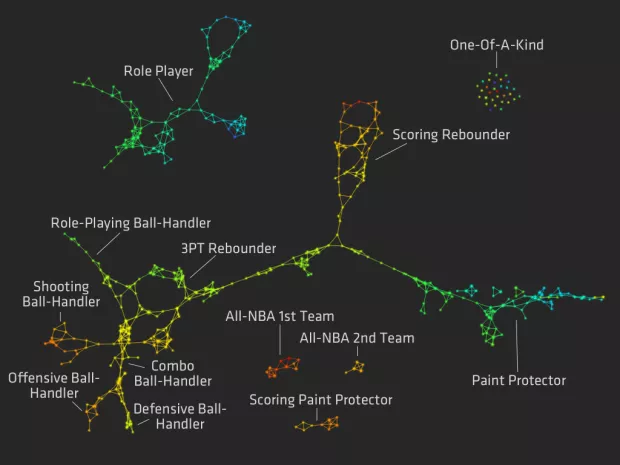

The clusters made it possible to discover player roles that might not have been noticed otherwise. Here's an [article](https://flowingdata.com/2012/03/21/redefining-nba-basketball-positions/) that describes how the clusters were created.

Clustering algorithms group similar rows together. There can be one or more groups in the data, and these groups form the clusters. As we look at the clusters, we can start to better understand the structure of the data.

Clustering is a key way to explore unknown data, and it's a very commonly used machine learning technique. In this lesson, we'll work on clustering US Senators based on how they voted.

### Dataset

In the US, the Senate votes on proposed legislation. Getting a bill passed by the Senate is a key step towards getting its provisions enacted. A majority vote is required to get a bill passed.

The results of these votes, known as roll call votes, are public, and available in a few places, including [here](https://github.com/unitedstates/congress). Read more about the US legislative system [here](https://en.wikipedia.org/wiki/Federal_government_of_the_United_States#Legislative_branch).

Senators typically vote in accordance with how their political party votes, known as voting along party lines. In the US, the 2 main political parties are the Democrats, who tend to be liberal, and the Republicans, who tend to be conservative. Senators can also choose to be unaffiliated with a party, and vote as Independents, although very few choose to do so.

114_congress.csv contains all of the results of roll call votes from the 114th Senate. Each row represents a single Senator, and each column represents a vote. A `0` in a cell means the Senator voted No on the bill, `1` means the Senator voted Yes, and `0.5` means the Senator abstained.

Here are the relevant columns:

`name` -- The last name of the Senator.
`party` -- the party of the Senator. The valid values are D for Democrat, R for Republican, and I for Independent.
Several columns numbered like `00001`, `00004`, etc. Each of these columns represents the results of a single roll call vote.

Below are the first three rows of the data. As we can see, the number of each bill is used as the column heading for its votes:
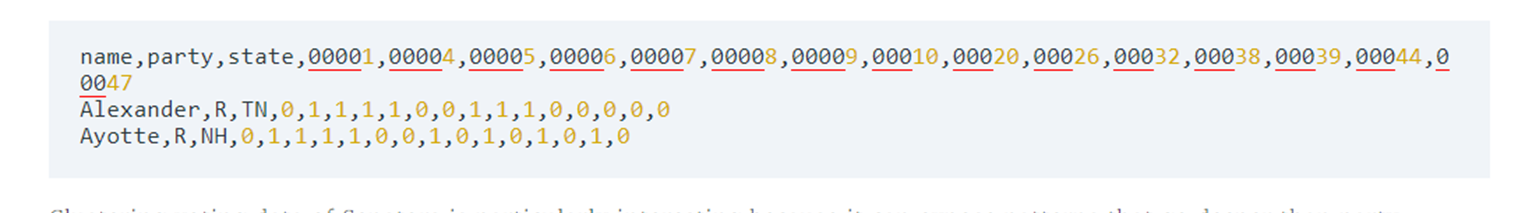

Clustering voting data of Senators is particularly interesting because it can expose patterns that go deeper than party affiliation. For example, some Republicans are more liberal than the rest of their party. Looking at voting data can help us discover the Senators who are more or less in the mainstream of their party.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Setting pandas display options for large data
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

In [2]:
votes = pd.read_csv('114_congress.csv')

In [3]:
votes.head()

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
0,Alexander,R,TN,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Ayotte,R,NH,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,Baldwin,D,WI,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,Barrasso,R,WY,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,Bennet,D,CO,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [4]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    100 non-null    object 
 1   party   100 non-null    object 
 2   state   100 non-null    object 
 3   00001   100 non-null    float64
 4   00004   100 non-null    float64
 5   00005   100 non-null    float64
 6   00006   100 non-null    float64
 7   00007   100 non-null    float64
 8   00008   100 non-null    float64
 9   00009   100 non-null    float64
 10  00010   100 non-null    float64
 11  00020   100 non-null    float64
 12  00026   100 non-null    float64
 13  00032   100 non-null    float64
 14  00038   100 non-null    float64
 15  00039   100 non-null    float64
 16  00044   100 non-null    float64
 17  00047   100 non-null    float64
dtypes: float64(15), object(3)
memory usage: 14.2+ KB


**Exercise**

Find how many Senators are in each party.
- Use the `value_counts()` method on the `party` column of votes. Print the results.
Find what the "average" vote for each bill was.
- Use the `mean()` method on the votes Dataframe. If the mean for a column is less than .5, more Senators voted against the bill, and vice versa if it's over .5. Print the results.

In [5]:
print(votes["party"].value_counts())
print(votes.mean())

R    54
D    44
I     2
Name: party, dtype: int64
00001    0.325
00004    0.575
00005    0.535
00006    0.945
00007    0.545
00008    0.415
00009    0.545
00010    0.985
00020    0.525
00026    0.545
00032    0.410
00038    0.480
00039    0.510
00044    0.460
00047    0.370
dtype: float64


To group Senators together, we need some way to figure out how "close" the Senators are to each other. We'll then group together the Senators that are the closest. We can actually discover this distance mathematically, by finding how similar the votes of two Senators are. The closer together the voting records of two Senators, the more ideologically similar they are (voting the same way indicates that you share the same views).

To find the distance between two rows, we can use Euclidean distance. The formula is:
$$d = \sqrt{(q_1-p_1)^2 + (q_2-p_2)^2 + \cdots + (q_n-p_n)^2}$$

Let's say we have two Senator's voting records:

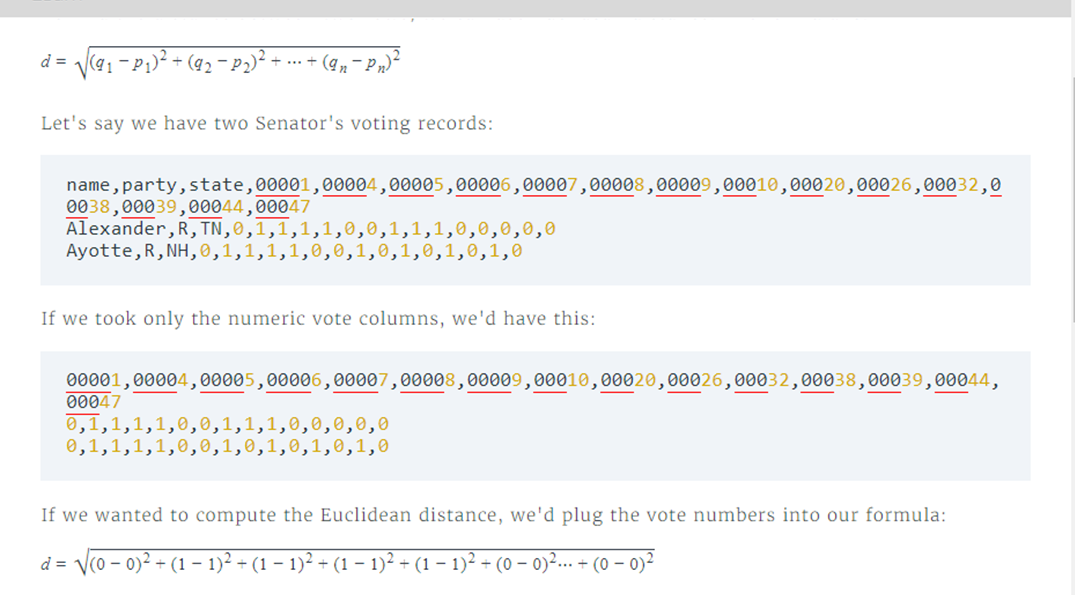

If we wanted to compute the Euclidean distance, we'd plug the vote numbers into our formula:
$$d = \sqrt{(0-0)^2 + (1-1)^2 + (1-1)^2 + (1-1)^2 + (1-1)^2 + (0-0)^2 \cdots + (0-0)^2}$$

It can be seen that these Senators are very similar! If you look at the votes above, they only disagree on 3 bills. The final Euclidean distance between these two Senators is `1.73`.

To compute Euclidean distance in Python, we can use the `euclidean_distances()` method in the scikit-learn library. The code below will find the Euclidean distance between the Senator in the first row and the Senator in the second row.

```
euclidean_distances(votes.iloc[0,3:], votes.iloc[1,3:])
```
It's necessary to only select columns after the first 3 because the first 3 are `name`, `party`, and `state`, which aren't numeric.


**Exercise**

Compute the Euclidean distance between the first row and the third row.
- Assign the result to `distance`

In [6]:
from sklearn.metrics.pairwise import euclidean_distances

# reshape is numpy command to reshape an array
# 1st and 2nd row
print(euclidean_distances(votes.iloc[0,3:].values.reshape(1, -1), votes.iloc[1,3:].values.reshape(1, -1)))
# 1st and 3nd row
distance = euclidean_distances(votes.iloc[0,3:].values.reshape(1, -1), votes.iloc[2,3:].values.reshape(1, -1))
distance

[[1.73205081]]


array([[3.31662479]])

### Initial Clustering
We'll use an algorithm called k-means clustering to split our data into clusters. k-means clustering uses Euclidean distance to form clusters of similar Senators. We'll dive more into the theory of k-means clustering and build the algorithm from the ground up in a later mission. For now, it's important to understand clustering at a high level, so we'll leverage the scikit-learn library to train a k-means model.

The k-means algorithm will group Senators who vote similarly on bills together, in clusters. Each cluster is assigned a center, and the Euclidean distance from each Senator to the center is computed. Senators are assigned to clusters based on which one they are closest to. From our background knowledge, we think that Senators will cluster along party lines.

The k-means algorithm requires us to specify the number of clusters upfront. Because we suspect that clusters will occur along party lines, and the vast majority of Senators are either Republicans or Democrats, we'll pick 2 for our number of clusters.

We'll use the KMeans class from scikit-learn to perform the clustering. Because we aren't predicting anything, there's no risk of overfitting, so we'll train our model on the whole dataset. After training, we'll be able to extract cluster labels that indicate what cluster each Senator belongs to.

We can initialize the model like this:
```
kmeans_model = KMeans(n_clusters=2, random_state=1)
```
The above code will initialize the k-means model with 2 clusters, and a random state of 1 to allow for the same results to be reproduced whenever the algorithm is run.

We'll then be able to use the [fit_transform()](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_transform) method to fit the model to `votes` and get the distance of each Senator to each cluster. The result will look like this:
```
array([[ 3.12141628,  1.3134775 ],
   [ 2.6146248 ,  2.05339992],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 1.43833966,  2.96866004],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 0.31287498,  3.30758755],
   ...
   ```
This is a NumPy array with two columns. The first column is the Euclidean distance from each Senator to the first cluster, and the second column is the Euclidean distance to the the second cluster. The values in the columns will indicate how "far" the Senator is from each cluster. The further away from the cluster, the less the Senator's voting history aligns with the voting history of the cluster.


**Exercise**
- Use the `fit_transform()` method to fit `kmeans_model` on the `votes` DataFrame. Only select columns after the first 3 from votes when fitting.
- Assign the result to `senator_distances`.

In [7]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2, random_state=1)
senator_distances = kmeans_model.fit_transform(votes.iloc[:, 3:])

### Exploring Clusters

We can use the Pandas method [`crosstab()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) to compute and display how many Senators from each party ended up in each cluster. The `crosstab()` method takes in two vectors or Pandas Series and computes how many times each unique value in the second vector occurs for each unique value in the first vector.
```
is_smoker =       [0,1,1,0,0,1]
has_lung_cancer = [1,0,1,0,1,0]
```

A 0 means False, and a 1 means True. A crosstab for the two above lists would look like this:

```
has_lung_cancer    0     1
smoker
0                  1     2
1                  2     1
```

We can extract the cluster labels for each Senator from kmeans_model using `kmeans_model.labels_`, then we can make a table comparing these labels to `votes["party"]` with `crosstab()`. This will show us if the clusters tend to break down along party lines or not.

**Exercise**
- Use the `labels_` attribute to extract the labels from kmeans_model. Assign the result to the variable `labels`.
- Use the `crosstab()` method to print out a table comparing `labels` to `votes["party"]`, in that order.

In [8]:
labels = kmeans_model.labels_
print(pd.crosstab(labels, votes["party"]))

party   D  I   R
row_0           
0       3  0  54
1      41  2   0


### Exploring Senators in the Wrong Clusters
Both of our clusters mostly broke down along party lines. The second cluster contains 41 Democrats, and both Independents. The first cluster contains 3 Democrats, and 54 Republicans.

No Republicans seem to have broken party ranks to vote with the Democrats, but 3 Democrats are more similar to Republicans in their voting than their own party. Let's explore these 3 in more depth so we can figure out why that is.

We can do this by subsetting votes to only select rows where the party column is D, and the labels variable is 0, indicating that the Senator is in the first cluster.
We can perform this subsetting with Pandas. The below code will select all Independents in the second cluster:

```
votes[(labels == 1) & (votes["party"] == "I")]
```
**When subsetting a DataFrame with multiple conditions, each condition needs to be in parentheses, and separated by &**

**Exercise**

- Select all senators who were assigned to the first cluster that were Democrats. Assign the subset to `democratic_outliers`.
- Print out democratic_outliers.

In [9]:
democratic_outliers = votes[(labels == 0) & (votes["party"] == "D")]
print(democratic_outliers)

        name party state  00001  00004  00005  00006  00007  00008  00009  \
42  Heitkamp     D    ND    0.0    1.0    0.0    1.0    0.0    0.0    1.0   
56   Manchin     D    WV    0.0    1.0    0.0    1.0    0.0    0.0    1.0   
74      Reid     D    NV    0.5    0.5    0.5    0.5    0.5    0.5    0.5   

    00010  00020  00026  00032  00038  00039  00044  00047  
42    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0  
56    1.0    1.0    0.0    0.0    1.0    1.0    0.0    0.0  
74    0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5  


One great way to explore clusters is to visualize them using matplotlib. Earlier, we computed a senator_distances array that shows the distance from each Senator to the center of each cluster. We can treat these distances as x and y coordinates, and make a scatterplot that shows the position of each Senator. This works because the distances are relative to the cluster centers.

While making the scatterplot, we can also shade each point according to party affiliation. This will enable us to quickly look at the layout of the Senators, and see who crosses party lines.

**Exercise**

Make a scatterplot using `plt.scatter()`. Pass in the following keyword arguments:
- x should be the first column of senator_distances.
- y should be the second column of senator_distances.
- c should be `labels`. This will shade the points according to label.
- `linewidths` should be set to 0
- Use `plt.show()` to show the plot.

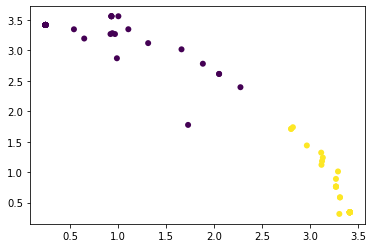

In [10]:
plt.scatter(x=senator_distances[:,0], y=senator_distances[:,1], c=labels, linewidths=0)
plt.show()

### Finding the Most Extreme

The most extreme Senators are those who are the furthest away from one cluster. For example, a radical Republican would be as far from the Democratic cluster as possible. Senators who are in between both clusters are more moderate, as they fall in between the views of the two parties.

If we look at the first few rows of `senator_distances`, we can start to see who is more extreme:
```
[
       [ 3.12141628,  1.3134775 ], # Slightly moderate, far from cluster 1, close to cluster 2.
       [ 2.6146248 ,  2.05339992], # Moderate, far from cluster 1, far from cluster 2.
       [ 0.33960656,  3.41651746], # Somewhat extreme, very close to cluster 1, very far from cluster 2.
       [ 3.42004795,  0.24198446], # Fairly extreme, very far from cluster 1, very close to cluster 2.
       ...
   ]
   ```
   
We'll create a formula to find extremists -- we'll cube the distances in both columns of `senator_distances`, then add them together. The higher the exponent we raise a set of numbers to, the more separation we'll see between small values and low values. For instance, squaring `[1,2,3]` results in `[1,4,9]`, and cubing it results in `[1,8,27]`.   

We cube the distances so that we can get a good amount of separation between the extremists who are farther away from a party, who have distances that look like `extremist = [3.4, .24]`, and moderates, whose distances look like `moderate = [2.6, 2]`. If we left the distances as is, we'd end up with `3.4 + .24 = 3.64`, and `2.6 + 2 = 4.6`, which would make the moderate, who is between both parties, seem extreme. If we cube, we instead end up with `3.4 ** 3 + .24 ** 3 = 39.3`, and `2.6 ** 3 + 2 ** 3 = 25.5`, which correctly identifies the extremist.

Here's how the first few ratings would look:
```
[
       [ 3.12141628,  1.3134775 ], # 32.67
       [ 2.6146248 ,  2.05339992], # 26.5
       [ 0.33960656,  3.41651746], # 39.9
       [ 3.42004795,  0.24198446], # 40
       ...
   ]
   ```

We can cube every value in senator_distances by typing `senator_distances ** 3`. To find the sum across every row, we'll need to use the NumPy `sum()` method, and pass in the keyword argument `axis=1`.

**Exercise**

Compute an extremism rating by cubing every value in `senator_distances`, then finding the sum across each row. Assign the result to `extremism`.
- Assign the extremism variable to the `extremism` column of votes.
- Sort votes on the extremism column, in descending order, using the `sort_values()` method on DataFrames.
- Print the top 10 most extreme Senators.

In [11]:
extremism = (senator_distances ** 3).sum(axis=1)
votes["extremism"] = extremism
votes.sort_values("extremism", inplace=True, ascending=False)
print(votes.head(10))

         name party state  00001  00004  00005  00006  00007  00008  00009  \
98     Wicker     R    MS    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
53   Lankford     R    OK    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
69       Paul     R    KY    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
80      Sasse     R    NE    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
26       Cruz     R    TX    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
48    Johnson     R    WI    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
47    Isakson     R    GA    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
65  Murkowski     R    AK    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
64      Moran     R    KS    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
30       Enzi     R    WY    0.0    1.0    1.0    1.0    1.0    0.0    1.0   

    00010  00020  00026  00032  00038  00039  00044  00047  extremism  
98    0.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0  46.250476